# Parameter fitting the Roche Model

## Generating epiabm data

In [24]:
import pyEpiabm as pe
import epimodels as em
import pandas as pd
import pints
# Load necessary libraries
import numpy as np
import epimodels as em
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten
from scipy.stats import nbinom
np.random.seed(42)

In [17]:
def build_regions(default_regions=['Luxembourg']):
    return default_regions

def build_age_groups(default_age_groups=['0-20', '20-40', '40-60', '60-80', '80-100']):
    return default_age_groups

def build_contact_matrices(age_groups=None):
    if age_groups is None:
        age_groups = build_age_groups()

    contact_data = np.array([
        [10, 5.2, 4.5, 3.8, 2.1],
        [0, 3, 2.8, 2.5, 1.7],
        [1.2, 2.4, 3.5, 2.8, 1.5],
        [0.8, 1.9, 2.6, 3.2, 2.0],
        [0.5, 1.2, 1.7, 2.5, 3.0]
    ])
    return [em.ContactMatrix(age_groups, contact_data)], [1]

def build_region_matrices(regions=None, age_groups=None):
    if regions is None:
        regions = build_regions()
    if age_groups is None:
        age_groups = build_age_groups()

    region_data = np.array([
        [1, 10, 8, 6, 5],
        [1, 6, 5, 4, 3],
        [1, 5, 6, 5, 4],
        [1, 4, 5, 6, 5],
        [1, 3, 4, 5, 6]
    ])
    return [[em.RegionMatrix(regions[0], age_groups, region_data)]], [1]


In [18]:
def build_npi_data():
    max_levels_npi = [3, 3, 3, 2, 2, 3, 2, 1, 3]
    targeted_npi = [True, True, True, True, True, False, False, False, True]
    general_npi = [[True] * 9, [True] * 9]
    reg_levels_npi = [[[3, 3, 3, 2, 2, 3, 2, 0, 3], [1, 1, 1, 1, 1, 1, 1, 0, 1]]]
    time_changes_npi = [1, 14]
    time_changes_flag = [1, 12]
    return max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag


In [19]:
def build_parameters(model, total_population=666430, total_days=200):
    # Create synthetic age-structure
    mean, variance = 38.90357303, 521.1594572
    std_dev = np.sqrt(variance)
    samples = np.random.normal(mean, std_dev, 10000)
    bin_edges = np.linspace(min(samples), max(samples), 6)
    hist, _ = np.histogram(samples, bins=bin_edges, density=True)
    proportions = hist / hist.sum()
    scaled_population = (proportions * total_population).astype(int).tolist()

    ICs = em.RocheICs(
        model=model,
        susceptibles_IC=[scaled_population],
        exposed_IC=[[100, 0, 0, 0, 0]],
        infectives_pre_IC=[[0, 0, 0, 0, 0]],
        infectives_asym_IC=[[0, 0, 0, 0, 0]],
        infectives_sym_IC=[[0, 0, 0, 0, 0]],
        infectives_pre_ss_IC=[[0, 0, 0, 0, 0]],
        infectives_asym_ss_IC=[[0, 0, 0, 0, 0]],
        infectives_sym_ss_IC=[[0, 0, 0, 0, 0]],
        infectives_q_IC=[[0, 0, 0, 0, 0]],
        recovered_IC=[[0, 0, 0, 0, 0]],
        recovered_asym_IC=[[0, 0, 0, 0, 0]],
        dead_IC=[[0, 0, 0, 0, 0]]
    )

    compartment_times = em.RocheCompartmentTimes(
        model=model,
        k=4.59,
        kS=0.5,
        kQ=1,
        kR=[7]*model._num_ages,
        kRI=[14]*model._num_ages
    )

    proportion_parameters = em.RocheProportions(
        model=model,
        Pa=0.34 * np.ones(len(model.age_groups_names())),
        Pss=0.0,
        Pd=0.15 * np.ones(len(model.age_groups_names()))
    )

    transmission_parameters = em.RocheTransmission(
        model=model,
        beta_min=0.01,
        beta_max=0.3,
        bss=2,
        gamma=1,
        s50=50
    )

    simulation_parameters = em.RocheSimParameters(
        model=model,
        region_index=1,
        method='RK45',
        times=np.arange(1, total_days+1, 1).tolist()
    )

    parameters = em.RocheParametersController(
        model=model,
        ICs=ICs,
        compartment_times=compartment_times,
        proportion_parameters=proportion_parameters,
        transmission_parameters=transmission_parameters,
        simulation_parameters=simulation_parameters
    )

    return parameters


In [20]:
def build_roche_model():
    model = em.RocheSEIRModel()

    regions = build_regions()
    age_groups = build_age_groups()

    model.set_regions(regions)
    model.set_age_groups(age_groups)

    contact_matrices, time_changes_contact = build_contact_matrices(age_groups)
    region_matrices, time_changes_region = build_region_matrices(regions, age_groups)
    npi_data = build_npi_data()

    model.read_contact_data(contact_matrices, time_changes_contact)
    model.read_regional_data(region_matrices, time_changes_region)
    model.read_npis_data(*npi_data)

    parameters = build_parameters(model)

    return model, parameters


In [22]:
def plot_full_compartments(output, parameters):
    """
    Plot the full Roche model compartments over time.
    """
    time_steps = np.array(parameters.simulation_parameters.times)
    n_ages = parameters.model._num_ages
    compartment_names = parameters.model.output_names()

    plt.figure(figsize=(12, 6))

    for i, name in enumerate(compartment_names):
        series = output[:, i*n_ages:(i+1)*n_ages].sum(axis=1)
        plt.plot(time_steps, series, label=name, linewidth=2)

    plt.xlabel('Time (days)')
    plt.ylabel('Number of Individuals')
    plt.title('Evolution of Compartments in the SEIR Model')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)
    plt.show()


def plot_aggregated_seird(output, parameters):
    """
    Plot aggregated S, E, I, R, D compartments.
    """
    time_steps = np.array(parameters.simulation_parameters.times)
    n_ages = parameters.model._num_ages

    S = output[:, 0*n_ages : 1*n_ages].sum(axis=1)
    E = output[:, 1*n_ages : 2*n_ages].sum(axis=1)
    I = (
        output[:, 2*n_ages:9*n_ages].reshape(-1, 7, n_ages).sum(axis=1)
    ).sum(axis=1)
    R = (
        output[:, 9*n_ages:10*n_ages] +
        output[:, 10*n_ages:11*n_ages]
    ).sum(axis=1)
    D = output[:, 11*n_ages:12*n_ages].sum(axis=1)

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, S, label='Susceptible', linewidth=2)
    plt.plot(time_steps, E, label='Exposed', linewidth=2)
    plt.plot(time_steps, I, label='Infected', linewidth=2)
    plt.plot(time_steps, R, label='Recovered', linewidth=2)
    plt.plot(time_steps, D, label='Dead', linewidth=2)

    plt.xlabel('Time (days)')
    plt.ylabel('Number of Individuals')
    plt.title('Aggregated SEIRD Model Evolution')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)
    plt.show()


def plot_final_seird_by_age(output, parameters):
    """
    Plot SEIRD distribution at final time step, broken down by age group.
    """
    n_ages = parameters.model._num_ages
    age_groups = parameters.model.age_groups_names()

    final_output = output[-1, :]
    S = final_output[0*n_ages : 1*n_ages]
    E = final_output[1*n_ages : 2*n_ages]
    I = (
        final_output[2*n_ages:9*n_ages].reshape(7, n_ages).sum(axis=0)
    )
    R = (
        final_output[9*n_ages:10*n_ages] +
        final_output[10*n_ages:11*n_ages]
    )
    D = final_output[11*n_ages:12*n_ages]

    df_seird = pd.DataFrame({
        'Age Group': age_groups,
        'Susceptible': S,
        'Exposed': E,
        'Infected': I,
        'Recovered': R,
        'Dead': D
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.15
    index = np.arange(len(age_groups))

    ax.bar(index, df_seird['Susceptible'], bar_width, label='Susceptible')
    ax.bar(index + bar_width, df_seird['Exposed'], bar_width, label='Exposed')
    ax.bar(index + 2*bar_width, df_seird['Infected'], bar_width, label='Infected')
    ax.bar(index + 3*bar_width, df_seird['Recovered'], bar_width, label='Recovered')
    ax.bar(index + 4*bar_width, df_seird['Dead'], bar_width, label='Dead')

    ax.set_xlabel('Age Group')
    ax.set_ylabel('Number of Individuals')
    ax.set_title('SEIRD Distribution by Age (Final Day)')
    ax.set_xticks(index + 2*bar_width)
    ax.set_xticklabels(age_groups)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

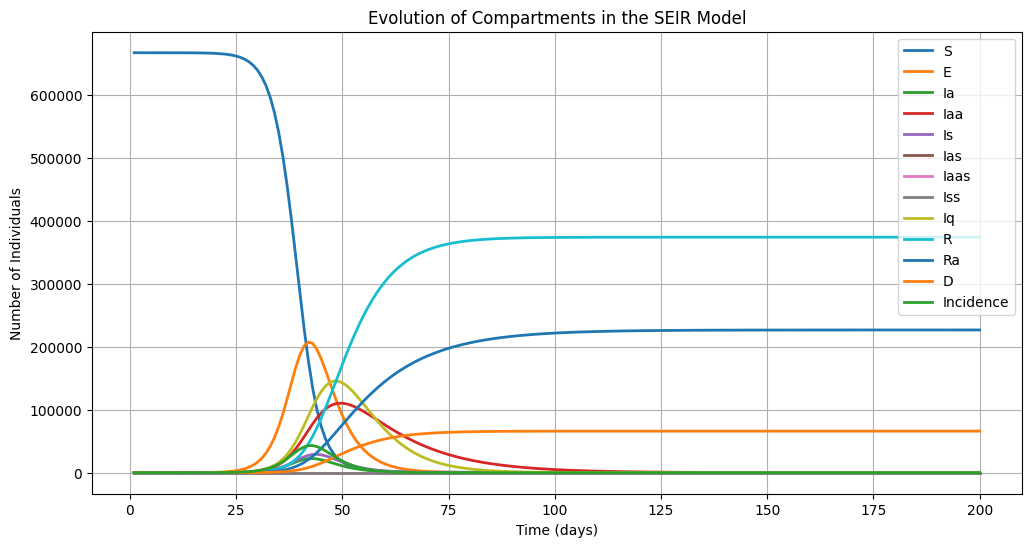

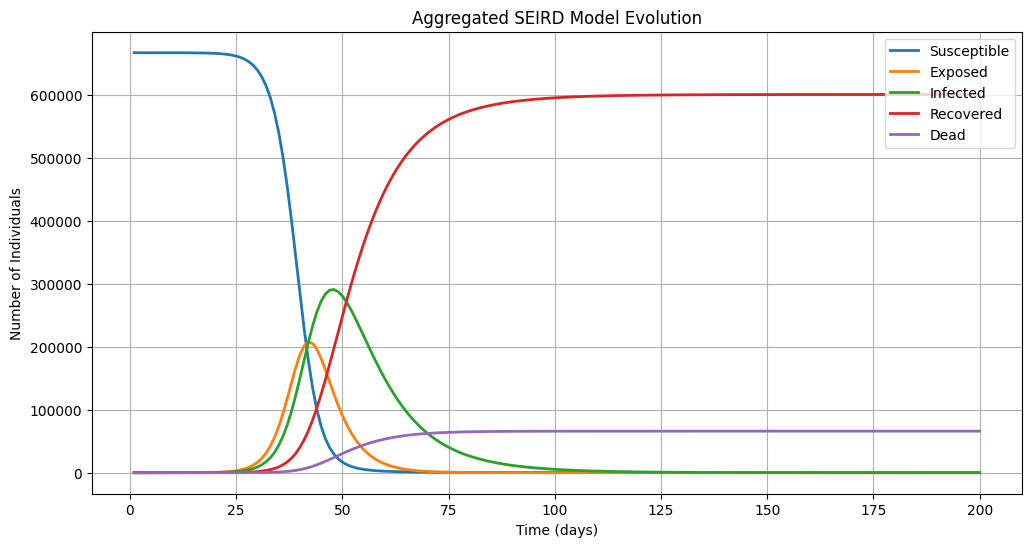

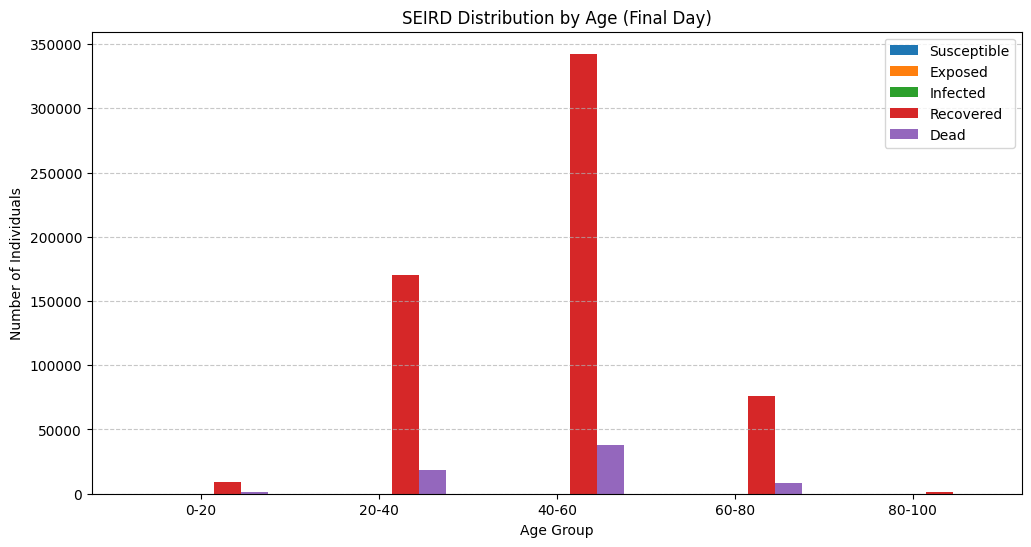

In [23]:
model, parameters = build_roche_model()
output = model.simulate(parameters)

plot_full_compartments(output, parameters)
plot_aggregated_seird(output, parameters)
plot_final_seird_by_age(output, parameters)

## Roche Inverse Problem

In [ ]:
def build_compartment_dataframe(output, parameters):
    """
    Build a Pandas DataFrame of compartments over time.
    """
    n_ages = parameters.model._num_ages
    time_steps = np.array(parameters.simulation_parameters.times)
    compartment_names = parameters.model.output_names()

    compartment_data = {
        name: output[:, i*n_ages:(i+1)*n_ages].sum(axis=1)
        for i, name in enumerate(compartment_names)
    }

    df = pd.DataFrame(compartment_data)
    df['Time'] = time_steps
    df = df.set_index('Time')
    
    return df

def build_manual_loglik(model, parameters, times, deaths_data,
                        max_levels_npi, targeted_npi, general_npi,
                        reg_levels_npi, time_changes_npi, time_changes_flag):
    """
    Build a manual log-likelihood function for parameter optimization.
    """

    def compute_loglik(x):
        flat = parameters()
        flat[-6], flat[-4] = x  # beta_min and bss
        model.read_npis_data(
            max_levels_npi,
            targeted_npi,
            general_npi,
            reg_levels_npi,
            time_changes_npi,
            time_changes_flag
        )

        sim = model._simulate(flat, times.tolist())
        mu = model.new_deaths(sim)
        obs = np.rint(deaths_data[0]).astype(int)

        nu = 1e-5
        n = mu / nu
        p = 1 / (1 + nu)
        ll = nbinom.logpmf(obs, n=n, p=p)

        # Handle cases where mu = 0 carefully
        zero_mu = (mu == 0)
        zero_obs = (obs == 0)
        ll = np.where(zero_mu & zero_obs, 0.0, ll)
        ll = np.where(zero_mu & ~zero_obs, -np.inf, ll)

        return np.sum(ll)

    class ManualLogPDF(pints.LogPDF):
        def n_parameters(self): return 2
        def __call__(self, x): return compute_loglik(x)

    return ManualLogPDF()

def run_manual_optimization(loglik, prior_bounds=[[0, 0], [1, 10]], x0=[0.2, 3.0]):
    """
    Run CMA-ES optimization on a manual log-likelihood.
    """
    prior = pints.UniformLogPrior(prior_bounds[0], prior_bounds[1])
    posterior = pints.LogPosterior(loglik, prior)

    opt = pints.OptimisationController(posterior, x0, method=pints.CMAES)
    opt.set_log_to_screen(True)
    opt.set_max_unchanged_iterations(100, threshold=1e-3)

    found_params, found_val = opt.run()

    return found_params, found_val

In [56]:
def build_deaths_data(output, parameters):
    """
    Build daily deaths data from cumulative D compartment, per age group.
    """
    n_ages = parameters.model._num_ages
    columns = parameters.model.output_names()
    total_days = len(parameters.simulation_parameters.times)

    # Reshape output to (T, C, A)
    all_data = output.reshape((total_days, len(columns), n_ages))
    all_data = np.rint(all_data).astype(int)

    # Extract cumulative deaths compartment ("D")
    D_cum = all_data[:, columns.index('D'), :]  # shape (T, A)

    # Compute daily deaths by differencing over time
    daily_deaths = np.diff(D_cum, axis=0)

    # Prepend a row of zeros for day 1
    D_obs = np.vstack([
        np.zeros((1, n_ages), dtype=int),
        daily_deaths
    ])

    # Wrap into a list to match expected format
    return [D_obs]



In [58]:
def plot_fit_vs_data(model, parameters, found_params, deaths_data, 
                     max_levels_npi, targeted_npi, general_npi, 
                     reg_levels_npi, time_changes_npi, time_changes_flag):
    """
    Plot fitted model deaths vs original synthetic deaths data.
    """

    # Update the model with found parameters
    flat = parameters()
    flat[-6], flat[-4] = found_params  # Update beta_min and bss
    model.read_npis_data(
        max_levels_npi,
        targeted_npi,
        general_npi,
        reg_levels_npi,
        time_changes_npi,
        time_changes_flag
    )

    # Simulate model output with found parameters
    times = parameters.simulation_parameters.times
    sim = model._simulate(flat, times)

    # Compute daily deaths from simulation
    n_ages = parameters.model._num_ages
    total_days = len(times)
    columns = parameters.model.output_names()

    all_data = sim.reshape((total_days, len(columns), n_ages))
    all_data = np.rint(all_data).astype(int)

    D_cum_sim = all_data[:, columns.index('D'), :]  # cumulative deaths
    daily_deaths_sim = np.diff(D_cum_sim, axis=0)
    daily_deaths_sim = np.vstack([
        np.zeros((1, n_ages), dtype=int),
        daily_deaths_sim
    ])

    # Original synthetic deaths (from deaths_data)
    daily_deaths_obs = deaths_data[0]  # shape (T, A)

    # Sum across age groups
    daily_deaths_obs_total = daily_deaths_obs.sum(axis=1)
    daily_deaths_sim_total = daily_deaths_sim.sum(axis=1)

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(times, daily_deaths_obs_total, label='Original Synthetic Data', linewidth=2)
    plt.plot(times, daily_deaths_sim_total, label='Best-fit Model Prediction', linestyle='--', linewidth=2)
    plt.xlabel('Time (days)')
    plt.ylabel('Daily Deaths')
    plt.title('Fitted Model vs Original Data')
    plt.legend()
    plt.grid(True)
    plt.show()

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -7420.663 -7420.663   0:03.9
1     12    -1187.094 -1187.094   0:06.2
2     18    -1187.094 -1228.191   0:06.5
3     24    -1187.094 -12639.19   0:07.4
20    126   -1163.405 -1165.546   0:35.6
40    246   -1161.936 -1161.936   1:17.7
60    366   -1161.936 -1161.936   2:02.8
80    486   -1161.936 -1161.936   2:49.0
100   606   -1161.936 -1161.936   3:30.6
120   726   -1161.936 -1161.936   4:13.9
123   738   -1161.936 -1161.936   4:18.7
Halting: No significant change for 100 iterations.
Found parameters: [0.00999807 3.11574149]
Log-posterior value: -1161.9359748848938


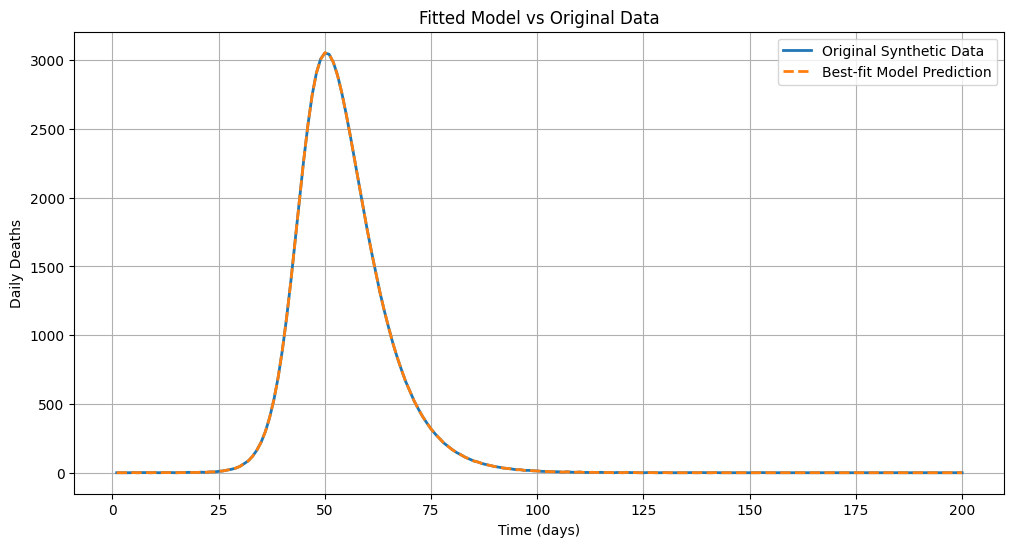

In [59]:
# Build the model
model, parameters = build_roche_model()
output = model.simulate(parameters)



# Build compartments DataFrame
deaths_data = build_deaths_data(output, parameters)


max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag = build_npi_data()


# Build manual log-likelihood
loglik = build_manual_loglik(
    model=model,
    parameters=parameters,
    times=np.array(parameters.simulation_parameters.times),
    deaths_data=deaths_data, 
    max_levels_npi=max_levels_npi,
    targeted_npi=targeted_npi,
    general_npi=general_npi,
    reg_levels_npi=reg_levels_npi,
    time_changes_npi=time_changes_npi,
    time_changes_flag=time_changes_flag
)

# Run optimization
found_params, found_val = run_manual_optimization(loglik)

print("Found parameters:", found_params)
print("Log-posterior value:", found_val)

plot_fit_vs_data(
    model=model,
    parameters=parameters,
    found_params=found_params,
    deaths_data=deaths_data,
    max_levels_npi=max_levels_npi,
    targeted_npi=targeted_npi,
    general_npi=general_npi,
    reg_levels_npi=reg_levels_npi,
    time_changes_npi=time_changes_npi,
    time_changes_flag=time_changes_flag
)